In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.functional import F

import os

In [2]:
with open("input.txt", "r") as file:
    text_corpus =   file.read()
    


In [3]:
print(text_corpus[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [4]:

unique_chars = sorted(set(text_corpus))


char_to_token = {unique_chars[i]:i for i in range(len(unique_chars))}

token_to_char =  {i:unique_chars[i] for i in range(len(unique_chars))}


In [5]:
char_to_token

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '3': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'A': 13,
 'B': 14,
 'C': 15,
 'D': 16,
 'E': 17,
 'F': 18,
 'G': 19,
 'H': 20,
 'I': 21,
 'J': 22,
 'K': 23,
 'L': 24,
 'M': 25,
 'N': 26,
 'O': 27,
 'P': 28,
 'Q': 29,
 'R': 30,
 'S': 31,
 'T': 32,
 'U': 33,
 'V': 34,
 'W': 35,
 'X': 36,
 'Y': 37,
 'Z': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64}

### Tokenize text


In [13]:
tokenized_text_corpus = [char_to_token[c] for c in text_corpus]

In [14]:
len(tokenized_text_corpus)

1115394

In [15]:
# BLOCK_SIZE=128 #Context len
# BATCH_SIZE=16



In [16]:
def get_batch():
    starting_indeces = np.random.randint(0, len(tokenized_text_corpus) - BLOCK_SIZE - 1, BATCH_SIZE)

    X_batch = [torch.tensor(tokenized_text_corpus[i : i + BLOCK_SIZE], ) for i in starting_indeces]
    y_batch = [torch.tensor(tokenized_text_corpus[i + 1: i + BLOCK_SIZE + 1],) for i in starting_indeces]
    
    X_batch, y_batch = torch.stack(X_batch), torch.stack(y_batch)   
    return (X_batch, y_batch)

#x, y = get_batch()


### Self-Attention 

In [93]:
B, T, C = 4, 8, 6#Batch, Time, COntext

xbow = torch.randn((B, T, C))

average_context_mask = torch.tril(torch.ones((T, T))) 
average_context_mask = average_context_mask / torch.sum(average_context_mask, axis=1, keepdim=True)

In [94]:
##version2

average_context_mask

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [95]:
print(average_context_mask.shape,  " @ ", xbow.shape)

average_context_mask @ xbow # (T, T) @ (B, T, C) is casted as (B, T, T) @ (B, T, C) --> (B, T, C)


torch.Size([8, 8])  @  torch.Size([4, 8, 6])


tensor([[[ 2.6059e-01,  1.7421e+00, -6.0612e-01, -9.6870e-01,  7.0926e-01,
          -2.5871e-02],
         [-5.7439e-01,  1.3707e+00,  2.4504e-01, -3.1590e-01, -1.4025e-01,
           4.4155e-01],
         [-1.3688e-01,  7.0780e-01,  6.3422e-01,  3.9436e-01, -1.2794e-01,
           2.3398e-01],
         [-1.5556e-01,  6.7288e-01,  6.9752e-01,  3.8903e-01, -4.7709e-01,
           2.7200e-02],
         [-1.3120e-01,  6.4888e-01, -1.0739e-01,  3.9961e-02, -6.3086e-01,
          -1.9785e-01],
         [-2.4418e-01,  6.4407e-01, -2.7484e-01, -1.1960e-01, -4.7174e-01,
          -3.3197e-01],
         [-3.7982e-02,  2.9874e-01, -1.2206e-01, -1.7865e-01, -3.8803e-01,
          -3.8281e-01],
         [ 4.9382e-02, -9.9869e-02, -3.9206e-01, -1.6009e-01, -4.7328e-01,
           7.2666e-02]],

        [[ 5.1830e-02,  1.7329e+00, -5.0020e-03, -4.7684e-01,  1.5562e+00,
           1.4066e+00],
         [-6.8112e-02,  1.7609e+00, -6.7252e-01,  3.2239e-01,  3.3581e-01,
           2.5147e-01],
        

In [25]:
##version 3

average_context_mask = torch.zeros((T, T))
average_context_mask = average_context_mask.masked_fill(torch.tril(torch.ones(T, T)) == 0, float("-inf"))
average_context_mask = F.softmax(average_context_mask, dim=1)

### One head of Self-Attention

In [150]:
###KEY PART of self-attention

B, T, C = 4, 8, 32 #Batch, Time, Channels (size of Embedding vec)
x = torch.randn(B,T,C)

#SINGLE HEAD self-attention
HEAD_SIZE=16

key = nn.Linear(C, HEAD_SIZE, bias=False)
query = nn.Linear(C, HEAD_SIZE, bias=False)
value = nn.Linear(C, HEAD_SIZE, bias=False)

#way of thinking
#X - is private info about each token

# Key - I am token N and here's what I have 
# Query - I am token N and here's what I look for
# Value - I am token N and  here's what I will communicate to you if you find me interesting

k = key(x) # (B, T, H)
q = query(x)


#compute scores for each token wrt to other tokens
#by dot product of query with keys of other tokens
wei = q @ k.transpose(-2, -1) #(B, T, T)

#masking out future

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float("-inf")) #forbide to talk to future-tokens (DECODER)
wei = F.softmax(wei, dim=-1)


v = value(x)

out = wei @ v  #each token gathers appropriate values of other tokens 


## Now, previous tokens have different weights (attention)
print(out.shape) #(BATCH, TIME, Head-size)


torch.Size([4, 8, 16])


In [151]:
#weighted attention

torch.round(wei[0], decimals=2)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8700, 0.1300, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2200, 0.7700, 0.0100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7900, 0.0500, 0.0400, 0.1200, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0700, 0.4900, 0.0700, 0.0100, 0.3700, 0.0000, 0.0000, 0.0000],
        [0.0800, 0.5800, 0.0500, 0.0300, 0.1200, 0.1500, 0.0000, 0.0000],
        [0.0800, 0.3300, 0.0900, 0.1500, 0.2400, 0.0800, 0.0300, 0.0000],
        [0.0100, 0.6500, 0.0100, 0.0000, 0.2600, 0.0200, 0.0200, 0.0300]],
       grad_fn=<RoundBackward1>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

### MultiHead Attention

multihead attention is basically applying many self-attentions in parralles and concatenating results

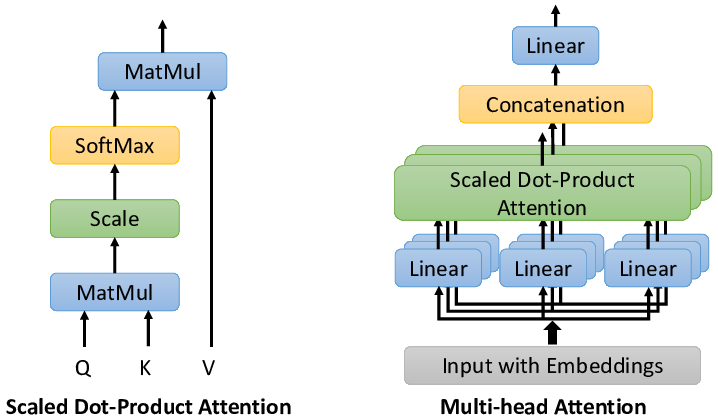

### TODO

1) We need to add simple feedforward NN on top of MultiHeadAttention Block
2) Add residual connections
3) Add Layer Norm

### Implementing MultiHead attention

In [19]:
#=========
#constants
N_EMBED=128
BATCH_SIZE=32
N_HEADS=8
VOCAB_SIZE=len(unique_chars)
BLOCK_SIZE=64 #Context length
N_BLOCKS=4
MAX_TOKENS=100
LR=0.001
EPOCHS=2000

#=======

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        
        self.head_size = head_size
        
        self.key_layer = nn.Linear(N_EMBED, head_size, bias=False)
        self.query_layer = nn.Linear(N_EMBED, head_size, bias=False)
        self.value_layer = nn.Linear(N_EMBED, head_size, bias=False)
        
    def forward(self, x):
        
        B, T, C = x.shape
        
        key = self.key_layer(x)
        query = self.query_layer(x)
        value = self.value_layer(x)
        
        #compute attention scores for each token wrt to other tokens
        attention_weights = (query @ key.transpose(-2, -1)) * C ** -0.5
        
        #mask out future
        tril = torch.tril(torch.ones(T, T))
        attention_weights = attention_weights.masked_fill(tril == 0, float("-inf"))
        #apply softmax to transform to prob distribution
        attention_weights = F.softmax(attention_weights, dim=-1)
        
        #gather values of interesting tokens and aggregate them for each token
        
        out = attention_weights @ value
        
        return out
        

In [20]:

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
        self.projection = nn.Linear(N_EMBED, N_EMBED)
        
        
    def forward(self, x):
        
        head_outs = [head(x) for head in self.heads]
        
        #concatenate outputs of heads
        head_outs_concated = torch.cat(head_outs, dim=-1)
        
        out = self.projection(head_outs_concated)
        
        
        return out
    
    
class TransformerBlock(nn.Module): 
    def __init__(self, n_emb, n_heads):
        super().__init__()

        
        self.multihead_attention = MultiHeadAttention(n_heads, n_emb // n_heads)
        
        
        self.feedforward_nn = nn.Sequential(
            nn.Linear(n_emb, 4 * n_emb),
            nn.ReLU(),
            nn.Linear(4 * n_emb, n_emb),
        )
        
        self.layer_norm1  = nn.LayerNorm(n_emb)
        self.layer_norm2 = nn.LayerNorm(n_emb)
        
    def forward(self, x): #output shape is same as input
        
        x = self.multihead_attention(x) + x #add residual connections
        x = self.feedforward_nn(x) + x 
        
        return x
    

In [21]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(VOCAB_SIZE, N_EMBED)
        self.position_embedding_table = nn.Embedding(VOCAB_SIZE, N_EMBED)
        
        #init transformer blocks
        self.blocks = nn.Sequential(*[TransformerBlock(N_EMBED, N_HEADS) for _ in range(N_BLOCKS)])
        self.layer_norm = nn.LayerNorm(N_EMBED)
        
        self.final_linear = nn.Linear(N_EMBED, VOCAB_SIZE) #logits
        
        
    def forward(self, idx, targets=None):
        #idx - tensor of indices of tokens
        
        
        B, T = idx.shape
        
        tok_emb = self.token_embedding_table(idx) #(B, T, N_EMB)
        pos_emb = self.position_embedding_table(torch.arange(T)) #(T, N_EMB)
        
        #sum token and position embedding
        x = pos_emb + tok_emb
        
        x = self.blocks(x) #(B, T, N_EMB)
        x = self.layer_norm(x) #(B, T, N_EMB)
        logits = self.final_linear(x) #(B, T, VOCAB_SIZE) - produces logits
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            
            logits = logits.view(B*T, C)
            
            targets = targets.view(B*T,)
            
            loss = F.cross_entropy(logits, targets)
        
        
        
        return logits, loss
        

    def generate(self, idx, max_tokens=100):
        
        # idx is (B, T) array of indices in the current context
        
        for _ in range(max_tokens):
            
            #crop last context
            idx_cond = idx[:, -BLOCK_SIZE:]
            
            #get predicitons
            logits, loss = self(idx_cond)
            
            #focus only on last time-step
            logits = logits[:, -1, :] #(B, C)
            
            #apply softmax
            tok_probs = F.softmax(logits, dim=-1)
            
            #sample from dist
            idx_next = torch.multinomial(tok_probs, num_samples=1)
            
            #append new token
            idx = torch.cat((idx, idx_next), dim=-1)
        return idx
        

In [22]:
model = BigramLanguageModel()


print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
    x_batch, y_batch = get_batch()
    
    logits, loss = model.forward(x_batch, y_batch)
    
    if ((epoch + 1) % 25 == 0 or epoch == 0):
        print("EPOCH# ", epoch + 1 ," LOSS = ", loss)
    
    # evaluate the loss
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

0.816833 M parameters
EPOCH#  1  LOSS =  tensor(4.3207, grad_fn=<NllLossBackward0>)
EPOCH#  25  LOSS =  tensor(2.8591, grad_fn=<NllLossBackward0>)
EPOCH#  50  LOSS =  tensor(2.5604, grad_fn=<NllLossBackward0>)
EPOCH#  75  LOSS =  tensor(2.4691, grad_fn=<NllLossBackward0>)
EPOCH#  100  LOSS =  tensor(2.4618, grad_fn=<NllLossBackward0>)
EPOCH#  125  LOSS =  tensor(2.4015, grad_fn=<NllLossBackward0>)
EPOCH#  150  LOSS =  tensor(2.4008, grad_fn=<NllLossBackward0>)
EPOCH#  175  LOSS =  tensor(2.3430, grad_fn=<NllLossBackward0>)
EPOCH#  200  LOSS =  tensor(2.2302, grad_fn=<NllLossBackward0>)
EPOCH#  225  LOSS =  tensor(2.2232, grad_fn=<NllLossBackward0>)
EPOCH#  250  LOSS =  tensor(2.1974, grad_fn=<NllLossBackward0>)
EPOCH#  275  LOSS =  tensor(2.1379, grad_fn=<NllLossBackward0>)
EPOCH#  300  LOSS =  tensor(2.0645, grad_fn=<NllLossBackward0>)
EPOCH#  325  LOSS =  tensor(2.0558, grad_fn=<NllLossBackward0>)
EPOCH#  350  LOSS =  tensor(2.0455, grad_fn=<NllLossBackward0>)
EPOCH#  375  LOSS =  te

In [23]:
context = torch.zeros((1, 1), dtype=torch.long)

generated_text = [token_to_char[int(t)] for t in model.generate(context, max_tokens=2000)[0]]

In [24]:
print("".join(generated_text[1:]))

the Kate, good succlud over
Roman. The vamits about I lie.
Vixf days lie prilot you. Pradce to rives
Move I mad men. it to yet these itse on he was the veart genlave sife, is
Too receed the do ours
As some of my for thy helps, or find eyes ye
That day and perfors him to ever no
To spoke. Your grass your honour.

MARCIUS:
Nave I lord the poorce hand, whind rurand.
She in being end the has trannamy to heaven
go him so.

SHENRDIEN:
God chento his issents. Charius!

PETHERD:
Harged!

CLADTER:
Why stat as with thinkes:
The heart he knows; thou have been as furge,
That Momans lament the pince to marring of me the crown
in moolt to my poortet. Thy roubles,
As you witse a paking powital.
Ah, and hopes life and of the pay priph:
Fellows him a garden spaked and ill not weak aft
For to somet that shouldst hem in and knows
Most suppening of Nail, follow of thas
thou thy tide the pilege up be arm
ThE sklend yet, that and to me.

ANGELO:
No, Lord Wating years and now, I am sacrow

PAULIS:
But, you t